# Arbol

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,regularizar,targetBooleano

[###] All Done                                              


In [4]:
from utilities import score, df_feat, df_targ, train_val

### Codigo a correr

In [5]:
MAX_JOBS = -1

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [6]:
runSimple = False
runValidated = False
runReg = True

**Save :** Guardar Modelo (pisa anterior)

In [7]:
saveSimple = True
saveValidated = True
saveReg = True

### Preprocesamiento

In [8]:
targetBooleano(df_targ, inplace=True)
reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)
df_feat_r = regularizar(df_feat)

In [9]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102356 entries, 0 to 102355
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            102356 non-null  int64  
 1   direccion_viento_tarde        102356 non-null  float64
 2   direccion_viento_temprano     102356 non-null  float64
 3   horas_de_sol                  102356 non-null  float64
 4   humedad_tarde                 102356 non-null  float64
 5   humedad_temprano              102356 non-null  float64
 6   llovieron_hamburguesas_hoy    102356 non-null  bool   
 7   mm_evaporados_agua            102356 non-null  float64
 8   mm_lluvia_dia                 102356 non-null  float64
 9   nubosidad_tarde               102356 non-null  float64
 10  nubosidad_temprano            102356 non-null  float64
 11  presion_atmosferica_tarde     102356 non-null  float64
 12  presion_atmosferica_temprano  102356 non-nul

In [10]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ )
train_targ = train_targ.llovieron_hamburguesas_al_dia_siguiente
val_targ = val_targ.llovieron_hamburguesas_al_dia_siguiente

In [11]:
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ )
train_targ_r = train_targ_r.llovieron_hamburguesas_al_dia_siguiente
val_targ_r = val_targ_r.llovieron_hamburguesas_al_dia_siguiente

## Entrenamiento

### Simple

In [12]:
if (runSimple):
    arbol_simple = DecisionTreeClassifier(
        random_state=1,
        max_depth=3,
        min_samples_split=200
    )
    arbol_simple.fit( train_feat, train_targ )
    
    # Guardar
    if(saveSimple):
        dump(arbol_simple, 'models/Tree/arbol_simple.sk') 
else:
    # Cargar
    arbol_simple = load('models/Tree/arbol_simple.sk')

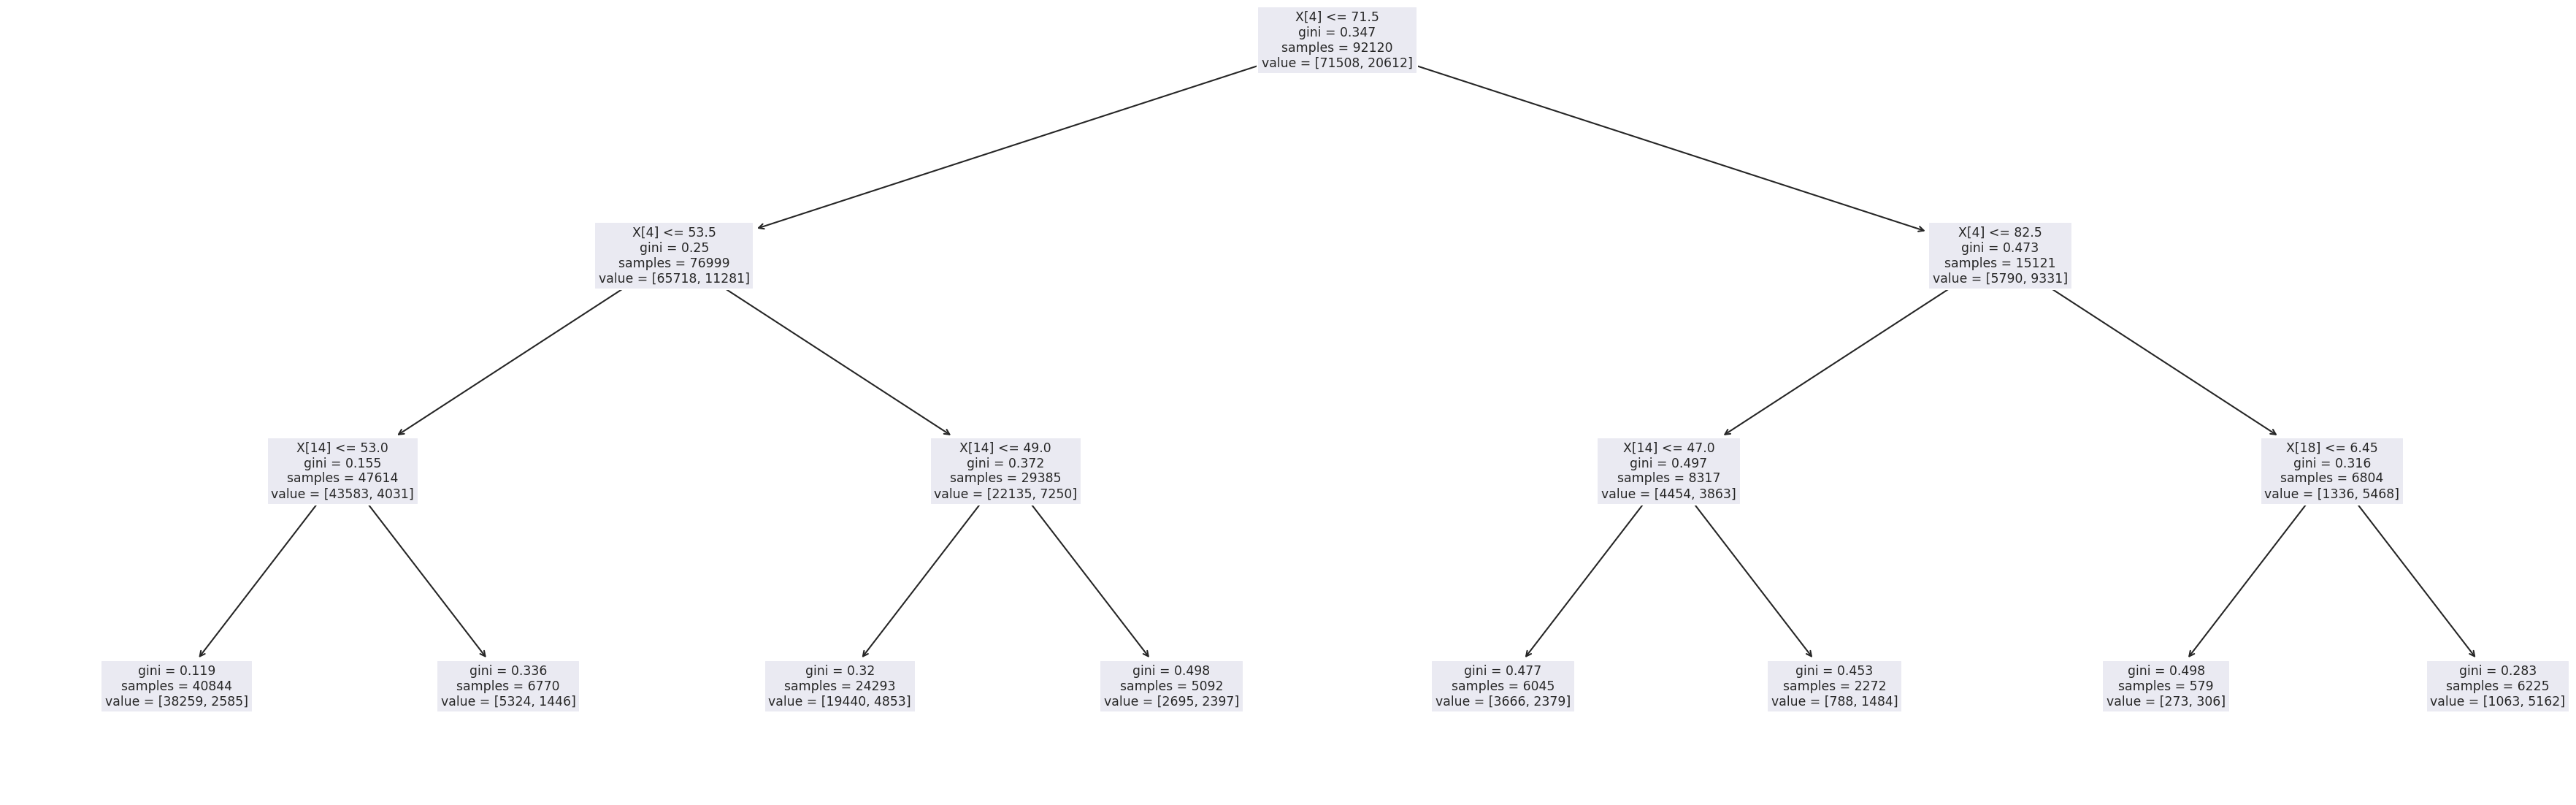

In [13]:
plt.figure(dpi=150,figsize=(15, 5))
tree.plot_tree(arbol_simple);

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs
AUC-ROC: 0.7930482173887717
ACCURACY: 0.8228800312622118
PRESICION: 0.734975369458128
RECALL: 0.325764192139738
CONFUSION MATRIX


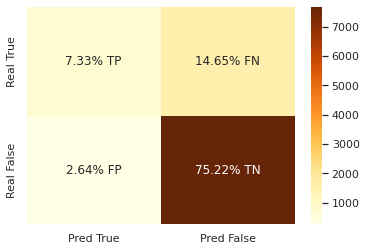

In [15]:
%time
pred = arbol_simple.predict(val_feat)
prob = arbol_simple.predict_proba(val_feat)
score(val_targ,pred, prob[:,1])

### Validado

In [16]:
if( runValidated ):
    arbol = DecisionTreeClassifier(random_state=1)
    params = {'max_depth': np.arange(1, 20, 1), 'min_samples_leaf': np.arange(50, 1000, 50)}
    
    gridSearch = GridSearchCV(
        arbol,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated):
        dump(gridSearch, 'models/Tree/gridSearch.sk')
else:
    # Cargar
    gridSearch = load('models/Tree/gridSearch.sk')

In [17]:
print(f"Best score: {gridSearch.best_score_}")
print(f"Best params {gridSearch.best_params_}")

Best score: 0.8531824348751025
Best params {'max_depth': 12, 'min_samples_leaf': 100}


In [18]:
arbol_grid = gridSearch.best_estimator_

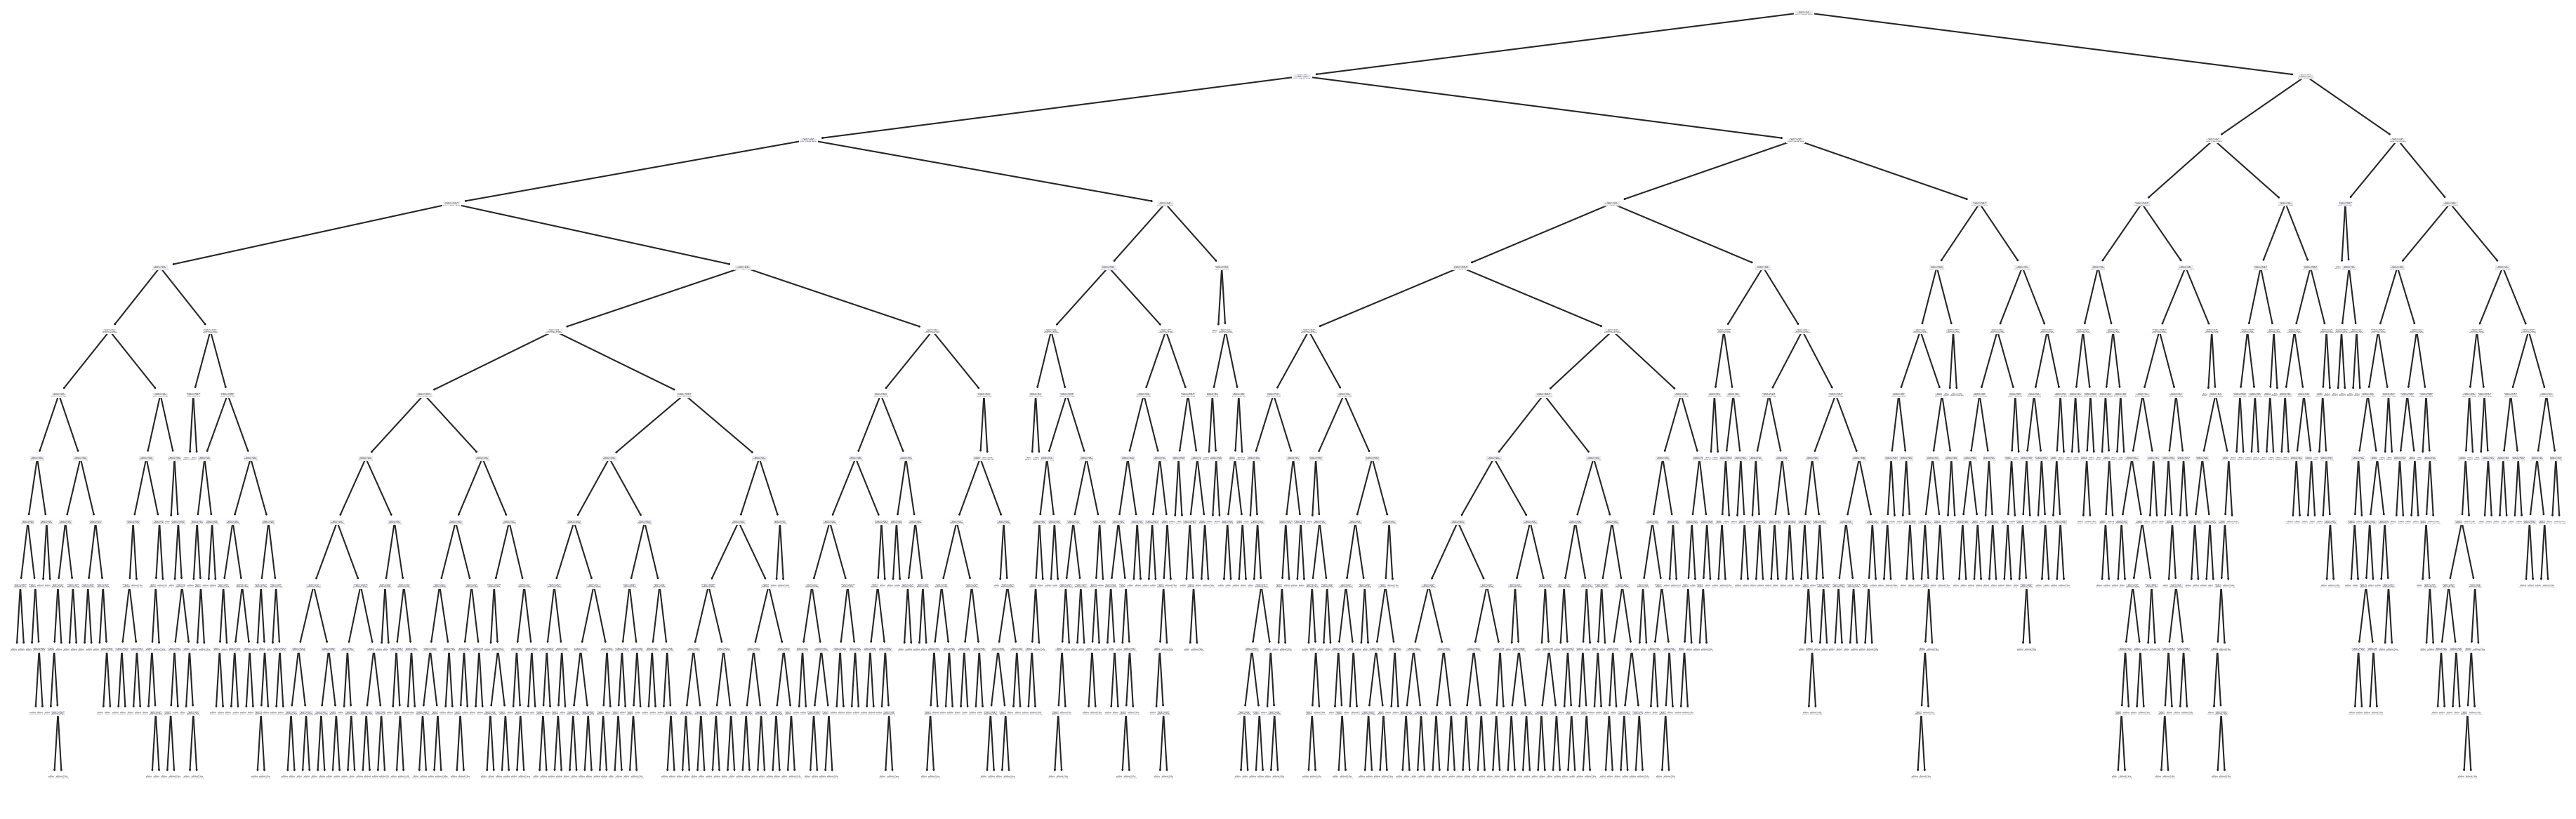

In [19]:
plt.figure(dpi=150,figsize=(15, 5))
tree.plot_tree(arbol_grid);

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
AUC-ROC: 0.8515858408888821
ACCURACY: 0.8352872215709262
PRESICION: 0.7
RECALL: 0.4615720524017467
CONFUSION MATRIX


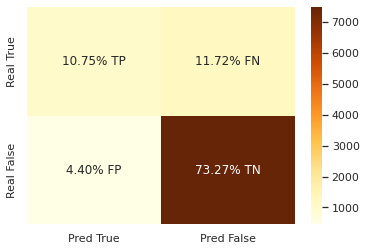

In [20]:
%time
pred = arbol_grid.predict(val_feat)
prob = arbol_grid.predict_proba(val_feat)
score(val_targ,pred, prob[:,1])

### Reg

In [21]:
if( runReg ):
    arbol_r = DecisionTreeClassifier(random_state=1)
    params = {'max_depth': np.arange(8, 12, 1), 'min_samples_leaf': np.arange(50, 150, 10)}
    
    grid_r = RandomizedSearchCV(
        arbol_r,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveReg):
        dump(grid_r, 'models/Tree/grid_r.sk')
        dump(grid_r.best_estimator_, 'models/Tree/arbol_r.sk')
else:
    # Cargar
    grid_r = load('models/Tree/grid_r.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [22]:
print(f"Best score: {grid_r.best_score_}")
print(f"Best params {grid_r.best_params_}")

Best score: 0.8542228225284187
Best params {'min_samples_leaf': 140, 'max_depth': 11}


In [23]:
arbol_r = grid_r.best_estimator_

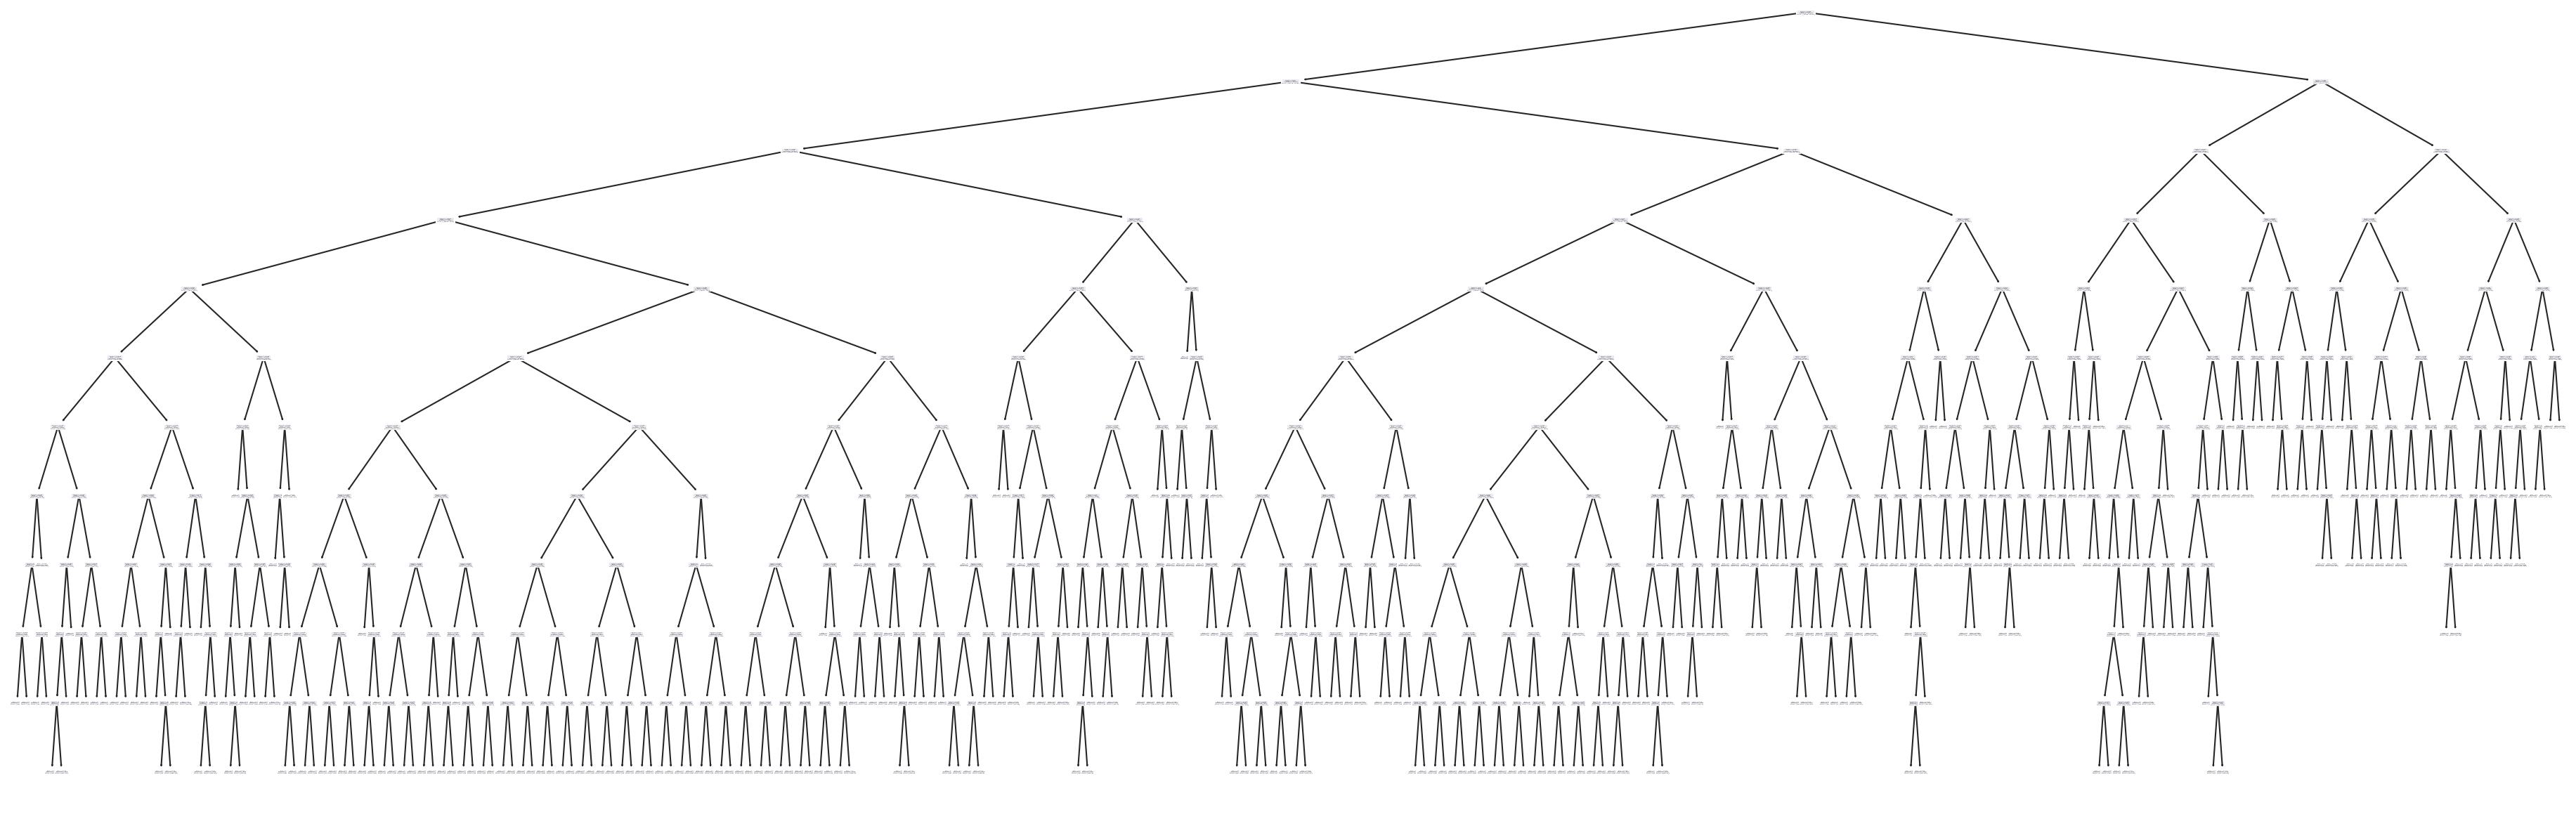

In [24]:
plt.figure(dpi=150,figsize=(15, 5))
tree.plot_tree(arbol_r);

AUC-ROC: 0.8531153792465958
ACCURACY: 0.8362641656897225
PRESICION: 0.7077131258457375
RECALL: 0.45676855895196505
CONFUSION MATRIX
CPU times: user 157 ms, sys: 9.87 ms, total: 167 ms
Wall time: 125 ms


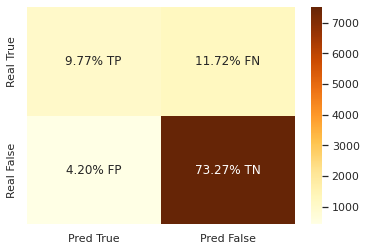

In [25]:
%%time
pred = arbol_r.predict(val_feat_r)
prob = arbol_r.predict_proba(val_feat_r)
score(val_targ_r,pred, prob[:,1])

## Resultados

**Simple:** \
Wall time: 5.01 µs \
AUC-ROC: 0.7930482173887717 \
ACCURACY: 0.8228800312622118 \
PRESICION: 0.734975369458128 \
RECALL: 0.325764192139738

**Grid:** \
Best score: 0.8531824348751025 \
Best params {'max_depth': 12, 'min_samples_leaf': 100}

Wall time: 4.05 µs \
AUC-ROC: 0.8515858408888821 \
ACCURACY: 0.8352872215709262 \
PRESICION: 0.7 \
RECALL: 0.4615720524017467

**Reg:** \
Best score: 0.8541379370038019 \
Best params {'min_samples_leaf': 120, 'max_depth': 11}

Wall time: 114 ms \
AUC-ROC: 0.8531153792465958 \
ACCURACY: 0.8334310277452129 \
PRESICION: 0.6913015042511446 \
RECALL: 0.4615720524017467


#### Conclusion

Se obtuvieron mejores metricas usando grid search & random search, ademas de estar validando con k-folds. \
No hay mucha diferencia entre estas dos, ni en metricas ni complejidad. \
Exportamos el modelo de rand search porque sus hiperparametros son un poco mas simples y recive features regularizadas (lo cual facilitara compararla con otros modelos que tambien lo hagan)